
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/previous/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Value', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points'],
      dtype='object')

In [5]:
df_original["Name"].unique().size

484

In [6]:
df.shape

(19421, 80)

In [7]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [8]:
# df = df[~df["FPL_pos"].isin(["GK"])]

In [9]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [10]:
df = df[df["Season"].isin(['2021-22', '2022-23'])]
df = df[df["FPL_pos"].isin(['FWD'])]

In [11]:
df = df.sort_values(by=["Name", "Date"])

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [12]:
rolling_gameweeks = [2, 4, 30]
# rolling_gameweeks = [5]

# to_predict = "FPL_points"
to_predict = "xP"
standard_features = [
             "Was_home", # Home/Away
             # "Team_rating", "Opp_rating", 
             "Rating_difference" # Team ratings
             ]
features_to_roll = [
                "Min", 
                # "Start", # time played
                'Gls', 
                # 'Sh', 'SoT', # Goals
                'Ast', # Assists
                # 'CrdY', 'CrdR', # Cards
                "xG", 'xA', # Expected
                'Team_CS', # Defence
                'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "T_succ",
                # 'bonus', 'bps', # Bonus
                # 'ICT_index', # ICT
                "FPL_points", 
                # "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos", "FPL_points"]

In [13]:
# df[df["Name"] == "Erling-Haaland"]

# Feature engineering

In [14]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [15]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [16]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        # print(form_means[form_means["Name"] == "Erling-Haaland"])
        form_means = form_means.fillna(method='bfill') # slightly incorrect, better to drop Nan
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df.reset_index(), form_means], axis=1)
        # df = df.merge(form_means, left_index=True, right_index=True)
        df = df.drop([col for col in df.columns if col.startswith('level')], axis=1)
        
    return df.reset_index(), features

In [17]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [18]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [19]:
df = label_encoding(df, "Start")

In [20]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [21]:
df, features = ohe(df, ["FPL_pos"], features)
if "GK" in df.columns:
    df = df.drop("GK", axis=1)
    features.remove("GK")

In [22]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + [to_predict])]

In [23]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [24]:
# dropping NaNs
df = df.dropna(axis=0)

In [25]:
# df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [26]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'FPL_points', 'FPL_points_2',
       'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW', 'Gls_2',
       'Gls_30', 'Gls_4', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Team', 'Team_CS_2', 'Team_CS_30',
       'Team_CS_4', 'Team_rating', 'Team_result_2', 'Team_result_30',
       'Team_result_4', 'Team_score_2', 'Team_score_30', 'Team_score_4',
       'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30', 'xG_4', 'xP'],
      dtype='object')

In [27]:
df.shape

(1842, 43)

In [28]:
# saving to file
df.set_index(["Name_original", "Season", "GW"], drop=False).to_csv("data/misc/df_features.csv", index=False) # keeping GKs on

In [29]:
df = df[~df["FPL_pos"].isin(["GK"])] # only outfield players

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [30]:
def shrink_df_to_top_players(df, n_players, min_fixtures):
    # Calculate average scores
    average_scores = df.groupby('Name_original')[to_predict].mean()
    
    # Calculate player counts
    player_counts = df['Name_original'].value_counts()
    
    # Filter out players with less than min_fixtures occurrences
    popular_players = player_counts[player_counts >= min_fixtures].index
    
    print("Unique players with min_fixtures:", popular_players.size)

    # Sort players by average scores
    sorted_players = average_scores.sort_values(ascending=False)

    # Get the top n_players players
    top_popular_players = sorted_players[sorted_players.index.isin(popular_players)].head(n_players)

    # Filter the original DataFrame
    top_players_df = df[df['Name_original'].isin(top_popular_players.index)]
    
    print("Unique players left:", top_players_df['Name_original'].unique().size)
    
    return top_players_df

In [31]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [32]:
df_train = shrink_df_to_top_players(df, 550, 10)
# df_train["Name_original"].unique()

Unique players with min_fixtures: 44
Unique players left: 44


In [33]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [34]:
# training data
X_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [35]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [36]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [37]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((1569, 33), (30, 33), (249, 33))

# Model

In [38]:
# model = GradientBoostingRegressor(random_state=42)
model = XGBRegressor(
        # random_state=42,
        # n_estimators=500,
        # early_stopping_rounds=5,
        # learning_rate=0.2
    )
# model = RandomForestRegressor(random_state=42)

In [39]:
%%time
model.fit(
        X_train, 
        y_train,
        # eval_set=[(X_test_all_remaining, y_test_all_remaining)],
        # verbose=False
    )

CPU times: total: 1.45 s
Wall time: 213 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Getting predictions

In [40]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + [to_predict] + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [41]:
preds, predictions = get_predictions(model, df, X_test)

In [42]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [43]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'FPL_points', 'FPL_points_2',
       'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW', 'Gls_2',
       'Gls_30', 'Gls_4', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Team', 'Team_CS_2', 'Team_CS_30',
       'Team_CS_4', 'Team_rating', 'Team_result_2', 'Team_result_30',
       'Team_result_4', 'Team_score_2', 'Team_score_30', 'Team_score_4',
       'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30', 'xG_4', 'xP'],
      dtype='object')

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [44]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")[to_predict].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [45]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [46]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [47]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)
    print("Avg pred vs avg true:", np.mean(predictions).round(2), "vs", np.mean(y_true).round(2).item())

In [48]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [49]:
# next gameweek
evaluate(model, df, predictions, y_test, all_gw=False)

MAE: 1.0936725636323292
MSE: 2.4892991596592657
Pairwise accuracy: 0.632183908045977
Pairwise accuracy @TOP100: 0.6009198082653193
Pairwise accuracy @TOP20: 0.5668608589622003
Avg pred vs avg true: 2.01 vs 2.16


In [50]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 1.1858431072138909
MSE: 2.652791402071093
Pairwise accuracy: 0.6009198082653193
Pairwise accuracy @TOP100: 0.632183908045977
Pairwise accuracy @TOP20: 0.5897435897435898
Avg pred vs avg true: 2.09 vs 2.1


In [51]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [52]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [53]:
features

['Was_home',
 'Rating_difference',
 'Min_2',
 'Gls_2',
 'Ast_2',
 'xG_2',
 'xA_2',
 'Team_CS_2',
 'Team_score_2',
 'Opp_score_2',
 'Team_result_2',
 'FPL_points_2',
 'Min_4',
 'Gls_4',
 'Ast_4',
 'xG_4',
 'xA_4',
 'Team_CS_4',
 'Team_score_4',
 'Opp_score_4',
 'Team_result_4',
 'FPL_points_4',
 'Min_30',
 'Gls_30',
 'Ast_30',
 'xG_30',
 'xA_30',
 'Team_CS_30',
 'Team_score_30',
 'Opp_score_30',
 'Team_result_30',
 'FPL_points_30',
 'FWD']

In [54]:
len(features)

33

# Predictions - next gameweek only

In [55]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
13,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,5.198107
15,Gabriel Fernando de Jesus,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,FWD,7.0,4.2,4.433820
16,Ivan Toney,31,2022-23,Brentford,Wolves,0.0,1782.324097,1717.951904,FWD,2.0,3.0,3.742731
10,Dominic Solanke,31,2022-23,Bournemouth,Tottenham,0.0,1665.276123,1851.721558,FWD,15.0,3.9,3.651098
4,Bryan Mbeumo,31,2022-23,Brentford,Wolves,0.0,1782.324097,1717.951904,FWD,2.0,2.2,3.349462
5,Callum Wilson,31,2022-23,Newcastle Utd,Aston Villa,0.0,1876.322510,1801.513550,FWD,1.0,1.0,2.986542
11,Eddie Nketiah,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,FWD,1.0,1.0,2.628416
26,Richarlison de Andrade,31,2022-23,Tottenham,Bournemouth,1.0,1851.721558,1665.276123,FWD,1.0,1.4,2.570281
25,Ollie Watkins,31,2022-23,Aston Villa,Newcastle Utd,1.0,1801.513550,1876.322510,FWD,16.0,6.5,2.424980
14,Evan Ferguson,31,2022-23,Brighton,Chelsea,0.0,1826.634155,1827.184204,FWD,1.0,2.1,1.998838


In [56]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
13,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,5.198107
19,Julián Álvarez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,1.0,1.533172


# Predictions - all remaining gameweeks

In [57]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
46,Callum Wilson,37,2022-23,Newcastle Utd,Leicester City,1.0,1879.238159,1707.616699,FWD,0.0,3.0,6.093445
83,Diogo Teixeira da Silva,38,2022-23,Liverpool,Southampton,0.0,1950.095581,1616.916626,FWD,13.0,5.0,6.051831
118,Erling Haaland,32,2022-23,Manchester City,Brighton,0.0,2089.150391,1826.267822,FWD,5.0,6.6,5.714005
136,Ivan Toney,33,2022-23,Brentford,Chelsea,0.0,1763.566284,1804.650879,FWD,2.0,1.0,5.481898
129,Gabriel Fernando de Jesus,34,2022-23,Arsenal,Chelsea,1.0,1921.972534,1789.972534,FWD,7.0,2.8,5.379530
112,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,5.198107
126,Gabriel Fernando de Jesus,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,FWD,7.0,4.2,4.433820
114,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2064.563232,1717.714233,FWD,8.0,6.0,4.387572
135,Ivan Toney,32,2022-23,Brentford,Aston Villa,1.0,1763.556641,1810.020996,FWD,9.0,4.4,4.380688
115,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,0.0,5.0,4.349505


In [58]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Mohamed Salah"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred


In [59]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Erling Haaland"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
112,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,5.198107
118,Erling Haaland,32,2022-23,Manchester City,Brighton,0.0,2089.150391,1826.267822,FWD,5.0,6.6,5.714005
113,Erling Haaland,33,2022-23,Manchester City,Arsenal,1.0,2057.953369,1928.582397,FWD,14.0,8.6,3.773131
114,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2064.563232,1717.714233,FWD,8.0,6.0,4.387572
115,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,0.0,5.0,4.349505
116,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2071.091064,1694.975464,FWD,7.0,2.6,3.289592
117,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2087.472656,1794.311890,FWD,1.0,1.4,3.838018
119,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2083.640381,1807.119507,FWD,0.0,0.0,4.338068


# Saving to file

In [60]:
preds_all_gameweeks.to_csv("predictions/all_predictions.csv", index=False)

In [61]:
pickle.dump(model, open("models/GBR.pkl", 'wb'))

# Feature importance and influence

In [62]:
explainer = shap.Explainer(model.predict, X_test_all_remaining)
shap_values = explainer(X_test_all_remaining)

Permutation explainer: 250it [00:25,  6.72it/s]                                                                                                                      


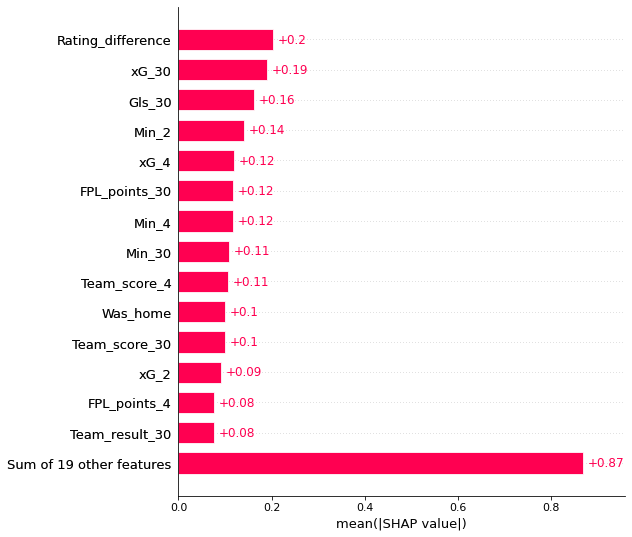

In [63]:
shap.plots.bar(shap_values, max_display=15)

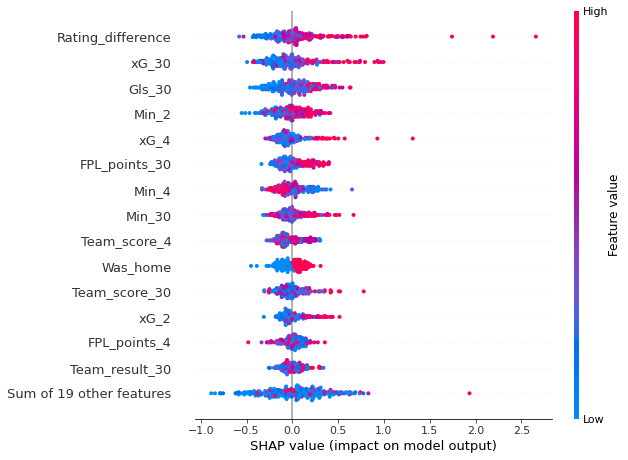

In [64]:
shap.plots.beeswarm(shap_values, max_display=15)

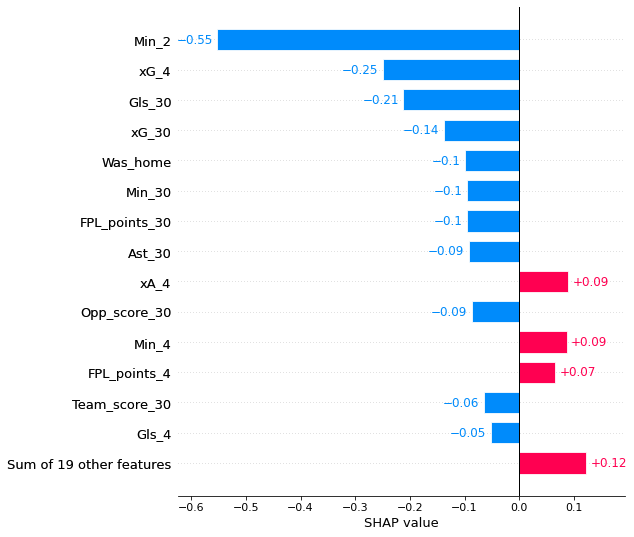

In [65]:
# explaining Erling Haaland`s score in gameweek 31
shap.plots.bar(shap_values[69], max_display=15)

In [66]:
# Salah vs Nottingham Forest
shap.plots.waterfall(shap_values[1396])

IndexError: index 1396 is out of bounds for axis 0 with size 249